In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

list_file = []
list_label = []
list_path = []

for path, subdirs, files in os.walk('/content/drive/MyDrive/Cat-Dog-Person'):
  for file in files:
    list_file.append(file)
    list_label.append(path.split('/')[-1])
    list_path.append(os.path.join(path, file))

print(len(list_file))

2100


In [ ]:
import pandas as pd

df = pd.DataFrame({'file' : list_file, 'label' : list_label, 'path' : list_path})

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['path'], df['label'], test_size=0.2, random_state=100)
df_train = pd.DataFrame({'x' : x_train, 'y' : y_train})
df_test = pd.DataFrame({'x' : x_test, 'y' : y_test})

print('Banyak Data Latih    : ', len(df_train))
print('Banyak Data Validasi : ', len(df_test))

Banyak Data Latih    :  1680
Banyak Data Validasi :  420


In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     rescale=1./255,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
test_generator = ImageDataGenerator()

data_train_generator = train_generator.flow_from_dataframe(dataframe=df_train, 
                                                          directory='/content/drive/MyDrive/Cat-Dog-Person',
                                                          target_size=(256, 256),
                                                          x_col='x', y_col='y')
data_test_generator = test_generator.flow_from_dataframe(dataframe=df_test, 
                                                          directory='/content/drive/MyDrive/Cat-Dog-Person',
                                                          target_size=(256, 256),
                                                          x_col='x', y_col='y')

Found 1680 validated image filenames belonging to 3 classes.
Found 420 validated image filenames belonging to 3 classes.


In [6]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(96, (11,11), strides=4, activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((3,3), strides=2),

    tf.keras.layers.Conv2D(256, (5,5), strides=1, activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3), strides=2),

    tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
    tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/model_deployment.h5', monitor='val_accuracy', mode='max', save_best_only=True)

history = model.fit(data_train_generator, epochs=20, validation_data=data_test_generator, callbacks=[mc])

Epoch 1/20
53/53 [==============================] - 497s 9s/step - loss: 1.1088 - accuracy: 0.3315 - val_loss: 1.0793 - val_accuracy: 0.3476
Epoch 2/20
53/53 [==============================] - 32s 604ms/step - loss: 1.0990 - accuracy: 0.3107 - val_loss: 1.0931 - val_accuracy: 0.3190
Epoch 3/20
53/53 [==============================] - 32s 600ms/step - loss: 1.0988 - accuracy: 0.3190 - val_loss: 1.0908 - val_accuracy: 0.3143
Epoch 4/20
53/53 [==============================] - 32s 604ms/step - loss: 1.0993 - accuracy: 0.3238 - val_loss: 1.1005 - val_accuracy: 0.3429
Epoch 5/20
53/53 [==============================] - 32s 610ms/step - loss: 1.0988 - accuracy: 0.3214 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 6/20
53/53 [==============================] - 32s 611ms/step - loss: 1.0995 - accuracy: 0.3238 - val_loss: 1.1002 - val_accuracy: 0.3429
Epoch 7/20
53/53 [==============================] - 32s 607ms/step - loss: 1.0987 - accuracy: 0.3482 - val_loss: 1.1001 - val_accuracy: 0.3405
E

14/14 [==============================] - 2s 129ms/step - loss: 1.0793 - accuracy: 0.3476
Train: 0.3333, Test: 0.3476


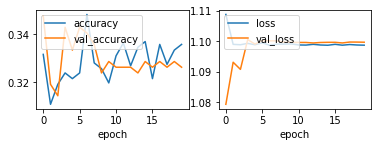

In [7]:
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('/content/drive/MyDrive/model_deployment.h5')

_, train_acc = model.evaluate(data_train_generator)
_, val_acc = model.evaluate(data_test_generator)
print('Train: %.4f, Test: %.4f' % (train_acc, val_acc))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 256)         8

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpyvwbval9/assets


In [10]:
with tf.io.gfile.GFile('/content/drive/MyDrive/model.tflite', 'wb') as f:
  f.write(tflite_model)